# Imports

In [1]:
#from src import Build_mc,Upload_geof,Upload_geof_geografica,Upload_litologia,plot_filtered_values,plot_raw_mag_data,plot_raw_gama_data,plot_histograms,plot_interpolated_histograms,describe_geologico, plotBoxplots,remove_negative_values,sintetic_grid,traditional_interpolation,plot_interpolated_histograms,pop_nodata
from src import *
from pylab import *

from tqdm import tqdm
from shapely.ops import transform
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import verde as vd
import numpy as np
import os
import pyproj
import verde_source as vds

import seaborn as sns
import xarray as xr
import matplotlib

from sklearn_som.som import SOM
from sklearn.preprocessing import StandardScaler

/home/ggrl/.config/ambiente_geologico/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib widget
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
'''def sintetic_grider(quadricula=None,p_size=None):
    ids = list(quadricula.keys())
    wgs84=pyproj.CRS('EPSG:4326')
    for id in tqdm(ids):
        folha = quadricula[id]['folha']
        utm = pyproj.CRS('EPSG:'+folha['EPSG'])
        carta_geografica = folha['geometry']
        project = pyproj.Transformer.from_crs(wgs84,utm, always_xy=True).transform
        carta_utm = transform(project,carta_geografica)
        break
'''

"def sintetic_grider(quadricula=None,p_size=None):\n    ids = list(quadricula.keys())\n    wgs84=pyproj.CRS('EPSG:4326')\n    for id in tqdm(ids):\n        folha = quadricula[id]['folha']\n        utm = pyproj.CRS('EPSG:'+folha['EPSG'])\n        carta_geografica = folha['geometry']\n        project = pyproj.Transformer.from_crs(wgs84,utm, always_xy=True).transform\n        carta_utm = transform(project,carta_geografica)\n        break\n"

## Construindo Quadrícula

In [ ]:
quadricula = Build_mc(escala='100k',ID=['SF23_VD','SF23_VC','SF23_YA','SF23_YB'],verbose=True)

In [5]:
list_ids = list(quadricula.keys())
#print(list_ids)

'''
for id in list_ids:
    print(f' - Folha: {id}')
    carta=quadricula[id]
    data_list = list(carta.keys())
    print(data_list)
    for data in data_list[4:]:
        print(f'    - {data}')
        print(f'        - {list(quadricula[id][data].columns)}')
'''    
def print_quadriculas(quadricula=quadricula):
    list_ids = list(quadricula.keys())
    for id in list_ids:
        print(f' - Folha {id}')
        carta = quadricula[id]
        list_carta_keys = list(carta.keys())
        print(f'    - {list_carta_keys}:')
        for key in list_carta_keys:
            print(carta[key])
            print('')

In [6]:
print_quadriculas(quadricula)

 - Folha SF23_VA_I
    - ['folha']:
EPSG                                                         32723
geometry         POLYGON ((-48 -20, -47.5 -20, -47.5 -20.5, -48...
geometry_proj    POLYGON ((186073.67956642434 7785705.973673515...
Name: SF23_VA_I, dtype: object

 - Folha SF23_VA_IV
    - ['folha']:
EPSG                                                         32723
geometry         POLYGON ((-48 -20.5, -47.5 -20.5, -47.5 -21, -...
geometry_proj    POLYGON ((187078.4168368245 7730316.295122661,...
Name: SF23_VA_IV, dtype: object

 - Folha SF23_VC_I
    - ['folha']:
EPSG                                                         32723
geometry         POLYGON ((-48 -21, -47.5 -21, -47.5 -21.5, -48...
geometry_proj    POLYGON ((188106.92493514047 7674924.30547923,...
Name: SF23_VC_I, dtype: object

 - Folha SF23_VC_IV
    - ['folha']:
EPSG                                                         32723
geometry         POLYGON ((-48 -21.5, -47.5 -21.5, -47.5 -22, -...
geometry_proj    POL

### Construindo grid regular sintético

_Verde gridder_

In [7]:
from verde import grid_coordinates

In [8]:
def batch_grid_coordinates(quadricula,spacing=0.001,pixel_register=True):
    list_id = list(quadricula.keys())
    
    #print(f' Folhas disponíveis: {list_id}')
    for id in list_id:
        folha = quadricula[id]
        print(f' Folha  {id}')

        df = quadricula[id]['folha']
        area = (df['geometry'].bounds[0],df['geometry'].bounds[2],
                df['geometry'].bounds[1],df['geometry'].bounds[3])
        
        xu,yu = grid_coordinates(region=area,spacing=spacing,pixel_register=pixel_register)
       
        df['coords'] = xu,yu
        df['area'] = area
        x={'area':df}
        quadricula[id].update(x)
        

batch_grid_coordinates(quadricula)

 Folha  SF23_VA_I
 Folha  SF23_VA_IV
 Folha  SF23_VC_I
 Folha  SF23_VC_IV
 Folha  SF23_YA_I
 Folha  SF23_YA_IV
 Folha  SF23_YC_I
 Folha  SF23_YC_IV
 Folha  SF23_VA_II
 Folha  SF23_VA_V
 Folha  SF23_VC_II
 Folha  SF23_VC_V
 Folha  SF23_YA_II
 Folha  SF23_YA_V
 Folha  SF23_YC_II
 Folha  SF23_YC_V
 Folha  SF23_VA_III
 Folha  SF23_VA_VI
 Folha  SF23_VC_III
 Folha  SF23_VC_VI
 Folha  SF23_YA_III
 Folha  SF23_YA_VI
 Folha  SF23_YC_III
 Folha  SF23_YC_VI
 Folha  SF23_VB_I
 Folha  SF23_VB_IV
 Folha  SF23_VD_I
 Folha  SF23_VD_IV
 Folha  SF23_YB_I
 Folha  SF23_YB_IV
 Folha  SF23_YD_I
 Folha  SF23_YD_IV
 Folha  SF23_VB_II
 Folha  SF23_VB_V
 Folha  SF23_VD_II
 Folha  SF23_VD_V
 Folha  SF23_YB_II
 Folha  SF23_YB_V
 Folha  SF23_YD_II
 Folha  SF23_YD_V
 Folha  SF23_VB_III
 Folha  SF23_VB_VI
 Folha  SF23_VD_III
 Folha  SF23_VD_VI
 Folha  SF23_YB_III
 Folha  SF23_YB_VI
 Folha  SF23_YD_III
 Folha  SF23_YD_VI
 Folha  SF23_XA_I
 Folha  SF23_XA_IV
 Folha  SF23_XC_I
 Folha  SF23_XC_IV
 Folha  SF23_ZA_I
 Fol

In [9]:
print_quadriculas(quadricula)

 - Folha SF23_VA_I
    - ['folha', 'area']:
EPSG                                                         32723
geometry         POLYGON ((-48 -20, -47.5 -20, -47.5 -20.5, -48...
geometry_proj    POLYGON ((186073.67956642434 7785705.973673515...
coords           ([[-47.9995, -47.99850000000001, -47.9975, -47...
area                                  (-48.0, -47.5, -20.5, -20.0)
Name: SF23_VA_I, dtype: object

EPSG                                                         32723
geometry         POLYGON ((-48 -20, -47.5 -20, -47.5 -20.5, -48...
geometry_proj    POLYGON ((186073.67956642434 7785705.973673515...
coords           ([[-47.9995, -47.99850000000001, -47.9975, -47...
area                                  (-48.0, -47.5, -20.5, -20.0)
Name: SF23_VA_I, dtype: object

 - Folha SF23_VA_IV
    - ['folha', 'area']:
EPSG                                                         32723
geometry         POLYGON ((-48 -20.5, -47.5 -20.5, -47.5 -21, -...
geometry_proj    POLYGON ((187078.416836824

In [10]:
quadricula['SF23_YA_V']['area']['coords']

(array([[-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005],
        [-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005],
        [-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005],
        ...,
        [-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005],
        [-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005],
        [-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005]]),
 array([[-22.9995, -22.9995, -22.9995, ..., -22.9995, -22.9995, -22.9995],
        [-22.9985, -22.9985, -22.9985, ..., -22.9985, -22.9985, -22.9985],
        [-22.9975, -22.9975, -22.9975, ..., -22.9975, -22.9975, -22.9975],
        ...,
        [-22.5025, -22.5025, -22.5025, ..., -22.5025, -22.5025, -22.5025],
        [-22.5015, -22.5015, -22.5015, ..., -22.5015, -22.5015, -22.5015],
        [-22.5005, -22.5005, -22.5005, ..., -22.5005, -22.5005, -22.5005]]))

In [11]:
quadricula['SF23_YA_V']['folha']['coords']

(array([[-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005],
        [-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005],
        [-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005],
        ...,
        [-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005],
        [-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005],
        [-47.4995, -47.4985, -47.4975, ..., -47.0025, -47.0015, -47.0005]]),
 array([[-22.9995, -22.9995, -22.9995, ..., -22.9995, -22.9995, -22.9995],
        [-22.9985, -22.9985, -22.9985, ..., -22.9985, -22.9985, -22.9985],
        [-22.9975, -22.9975, -22.9975, ..., -22.9975, -22.9975, -22.9975],
        ...,
        [-22.5025, -22.5025, -22.5025, ..., -22.5025, -22.5025, -22.5025],
        [-22.5015, -22.5015, -22.5015, ..., -22.5015, -22.5015, -22.5015],
        [-22.5005, -22.5005, -22.5005, ..., -22.5005, -22.5005, -22.5005]]))

## Adicionando dados brutos à Quadrícula

In [12]:
#Upload_geof(quadricula,'gama_line_1105','mag_line_1105',1000)
#gama_1039,mag_1039=Upload_geof(quadricula,'gama_1039','mag_1039',1000)

Upload_geof_geografica(quadricula,'gama_line_1105','mag_line_1105',0.01)

 21%|████████████▍                                             | 19/89 [00:01<00:05, 12.16it/s]

 - gama_line_1105 atualizado na folha: SF23_VC_III com 22615 pontos
 - mag_line_1105 atualizado na folha: SF23_VC_III com 227630 pontos
 - gama_line_1105 atualizado na folha: SF23_VC_VI com 38926 pontos
 - mag_line_1105 atualizado na folha: SF23_VC_VI com 391796 pontos
 - gama_line_1105 atualizado na folha: SF23_YA_III com 40452 pontos


 26%|██████████████▉                                           | 23/89 [00:01<00:05, 11.67it/s]

 - mag_line_1105 atualizado na folha: SF23_YA_III com 420921 pontos
 - mag_line_1105 atualizado na folha: SF23_YA_VI com 31311 pontos


 33%|██████████████████▉                                       | 29/89 [00:02<00:05, 11.69it/s]

 - mag_line_1105 atualizado na folha: SF23_VD_IV com 31783 pontos
 - gama_line_1105 atualizado na folha: SF23_YB_I com 76572 pontos
 - mag_line_1105 atualizado na folha: SF23_YB_I com 803396 pontos
 - gama_line_1105 atualizado na folha: SF23_YB_IV com 74864 pontos
 - mag_line_1105 atualizado na folha: SF23_YB_IV com 791210 pontos
 - gama_line_1105 atualizado na folha: SF23_YD_I com 37295 pontos


 37%|█████████████████████▌                                    | 33/89 [00:02<00:04, 11.51it/s]

 - mag_line_1105 atualizado na folha: SF23_YD_I com 385102 pontos
 - gama_line_1105 atualizado na folha: SF23_YD_IV com 22332 pontos
 - mag_line_1105 atualizado na folha: SF23_YD_IV com 259164 pontos


 42%|████████████████████████                                  | 37/89 [00:03<00:04, 11.51it/s]

 - mag_line_1105 atualizado na folha: SF23_VD_V com 24987 pontos
 - gama_line_1105 atualizado na folha: SF23_YB_II com 80239 pontos
 - mag_line_1105 atualizado na folha: SF23_YB_II com 844473 pontos
 - gama_line_1105 atualizado na folha: SF23_YB_V com 80287 pontos
 - mag_line_1105 atualizado na folha: SF23_YB_V com 832019 pontos


 44%|█████████████████████████▍                                | 39/89 [00:03<00:04, 11.07it/s]

 - gama_line_1105 atualizado na folha: SF23_YD_II com 86928 pontos
 - mag_line_1105 atualizado na folha: SF23_YD_II com 811667 pontos
 - gama_line_1105 atualizado na folha: SF23_YD_V com 37912 pontos
 - mag_line_1105 atualizado na folha: SF23_YD_V com 394903 pontos


 51%|█████████████████████████████▎                            | 45/89 [00:03<00:03, 11.46it/s]

 - mag_line_1105 atualizado na folha: SF23_VD_VI com 25830 pontos
 - gama_line_1105 atualizado na folha: SF23_YB_III com 77273 pontos
 - mag_line_1105 atualizado na folha: SF23_YB_III com 788652 pontos
 - gama_line_1105 atualizado na folha: SF23_YB_VI com 79157 pontos
 - mag_line_1105 atualizado na folha: SF23_YB_VI com 728574 pontos
 - gama_line_1105 atualizado na folha: SF23_YD_III com 95890 pontos


 55%|███████████████████████████████▉                          | 49/89 [00:04<00:03, 11.34it/s]

 - mag_line_1105 atualizado na folha: SF23_YD_III com 789509 pontos
 - gama_line_1105 atualizado na folha: SF23_YD_VI com 18565 pontos
 - mag_line_1105 atualizado na folha: SF23_YD_VI com 225801 pontos


 60%|██████████████████████████████████▌                       | 53/89 [00:04<00:03, 11.58it/s]

 - mag_line_1105 atualizado na folha: SF23_XC_IV com 24964 pontos
 - gama_line_1105 atualizado na folha: SF23_ZA_I com 46508 pontos
 - mag_line_1105 atualizado na folha: SF23_ZA_I com 510559 pontos
 - gama_line_1105 atualizado na folha: SF23_ZA_IV com 70338 pontos
 - mag_line_1105 atualizado na folha: SF23_ZA_IV com 644439 pontos
 - gama_line_1105 atualizado na folha: SF23_ZC_I com 80342 pontos


 64%|█████████████████████████████████████▏                    | 57/89 [00:04<00:02, 11.53it/s]

 - mag_line_1105 atualizado na folha: SF23_ZC_I com 718365 pontos


 69%|███████████████████████████████████████▊                  | 61/89 [00:05<00:02, 11.30it/s]

 - mag_line_1105 atualizado na folha: SF23_XC_V com 33548 pontos
 - gama_line_1105 atualizado na folha: SF23_ZA_II com 72848 pontos
 - mag_line_1105 atualizado na folha: SF23_ZA_II com 737013 pontos
 - gama_line_1105 atualizado na folha: SF23_ZA_V com 73667 pontos
 - mag_line_1105 atualizado na folha: SF23_ZA_V com 711132 pontos
 - gama_line_1105 atualizado na folha: SF23_ZC_II com 39856 pontos


 71%|█████████████████████████████████████████                 | 63/89 [00:05<00:02, 11.44it/s]

 - mag_line_1105 atualizado na folha: SF23_ZC_II com 412840 pontos


 78%|████████████████████████████████████████████▉             | 69/89 [00:05<00:01, 11.91it/s]

 - mag_line_1105 atualizado na folha: SF23_ZA_III com 14620 pontos
 - mag_line_1105 atualizado na folha: SF23_ZA_VI com 10814 pontos


100%|██████████████████████████████████████████████████████████| 89/89 [00:07<00:00, 11.80it/s]


In [13]:
Upload_geof_geografica(quadricula,'gama_line_1089','mag_line_1089')

100%|██████████████████████████████████████████████████████████| 89/89 [00:03<00:00, 24.32it/s]


In [14]:
quadricula['SF23_YA_III']['gama_line_1105'].head()

,X,Y,LATITUDE,LONGITUDE,CTCOR,eU,eTh,KPERC,UTHRAZAO,THKRAZAO,UKRAZAO,MDT
19061,316870.31,7567198.83,-21.990175,-46.773827,49.2,2.30,37.10,3.33,0.1,10.00,0.6,797.04
19062,316872.05,7567122.81,-21.990862,-46.773818,45.8,1.96,35.34,3.52,0.1,10.18,0.6,806.81
19063,316873.96,7567046.97,-21.991547,-46.773808,36.7,1.77,27.30,3.06,0.1,10.39,0.6,819.98
19064,316875.53,7566971.13,-21.992232,-46.773802,28.6,1.29,21.60,2.12,0.1,10.63,0.7,836.34
19065,316876.92,7566895.66,-21.992913,-46.773797,23.9,1.00,17.50,1.48,0.1,10.93,0.7,841.73


In [15]:
geof_list_ids = list(quadricula.keys())
for id in geof_list_ids:
    print(f' - Folha: {id}')
    carta=quadricula[id]
    data_list = list(carta.keys())
    print(data_list)
    for data in data_list[4:]:
        print(f'    - {data}')
        print(f'        - {list(quadricula[id][data].columns)}')
    print('')


 - Folha: SF23_VA_I
['folha', 'area']

 - Folha: SF23_VA_IV
['folha', 'area']

 - Folha: SF23_VC_I
['folha', 'area']

 - Folha: SF23_VC_IV
['folha', 'area']

 - Folha: SF23_YA_I
['folha', 'area']

 - Folha: SF23_YA_IV
['folha', 'area']

 - Folha: SF23_YC_I
['folha', 'area']

 - Folha: SF23_YC_IV
['folha', 'area']

 - Folha: SF23_VA_II
['folha', 'area']

 - Folha: SF23_VA_V
['folha', 'area']

 - Folha: SF23_VC_II
['folha', 'area']

 - Folha: SF23_VC_V
['folha', 'area']

 - Folha: SF23_YA_II
['folha', 'area']

 - Folha: SF23_YA_V
['folha', 'area']

 - Folha: SF23_YC_II
['folha', 'area']

 - Folha: SF23_YC_V
['folha', 'area']

 - Folha: SF23_VA_III
['folha', 'area']

 - Folha: SF23_VA_VI
['folha', 'area']

 - Folha: SF23_VC_III
['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha: SF23_VC_VI
['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha: SF23_YA_III
['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha: SF23_YA_VI
['folha', 'area', 'mag_line_1105']

 - 

In [16]:
quadricula=pop_nodata(quadricula)
len(quadricula.keys())

100%|██████████████████████████████████████████████████████| 89/89 [00:00<00:00, 105034.62it/s]


29

In [17]:
for id in list(quadricula.keys()):
    print(f' - Folha:  {id}')
    carta = quadricula[id]
    print(f'    - {list(carta.keys())}')
    print('')

 - Folha:  SF23_VC_III
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_VC_VI
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_YA_III
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_YA_VI
    - ['folha', 'area', 'mag_line_1105']

 - Folha:  SF23_VD_IV
    - ['folha', 'area', 'mag_line_1105']

 - Folha:  SF23_YB_I
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_YB_IV
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_YD_I
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_YD_IV
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_VD_V
    - ['folha', 'area', 'mag_line_1105']

 - Folha:  SF23_YB_II
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_YB_V
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_YD_II
    - ['folha', 'area', 'gama_line_1105', 'mag_lin

## Vizualisando Área de Cobertura

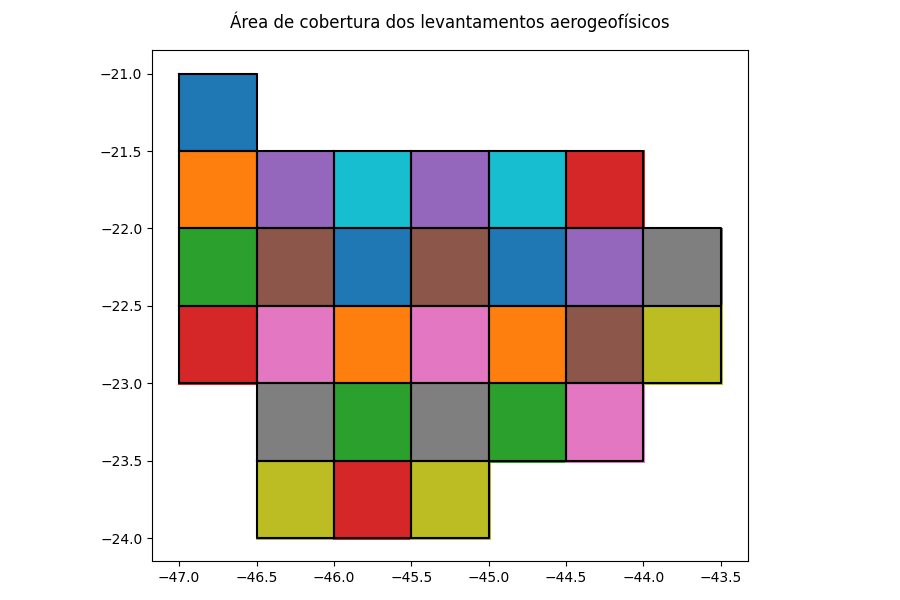

In [18]:
plt.figure(figsize=(9,6))
for id in list(quadricula.keys()):
    carta=quadricula[id]['area']
    plt.plot(*(carta['geometry']).exterior.xy,color='black')
    plt.axis('scaled')
    plt.scatter(carta['coords'][0],carta['coords'][1],s=1)    
plt.suptitle('Área de cobertura dos levantamentos aerogeofísicos')
plt.axis('scaled')
plt.tight_layout()

In [19]:
list(carta.keys())

['EPSG', 'geometry', 'geometry_proj', 'coords', 'area']

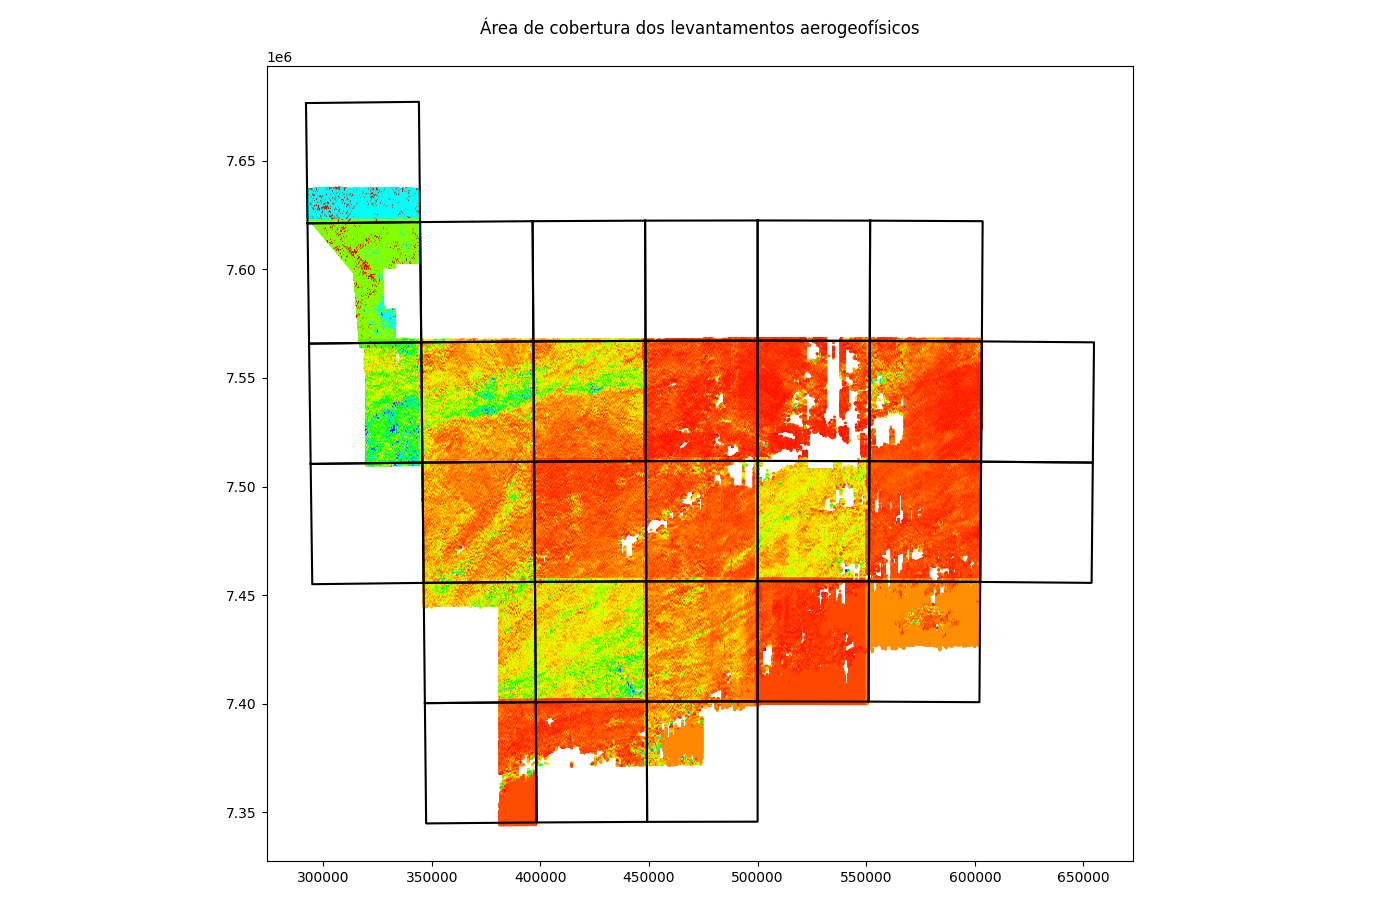

In [20]:
plt.figure(figsize=(14,9))
for id in list(quadricula.keys()):
    carta=quadricula[id]
    #print(carta.keys())
    plt.plot(*(carta['area']['geometry_proj']).exterior.xy,color='black')
    plt.axis('scaled')
    for data in list(carta.keys())[:]:
        if 'gama' in data:
            #print(data)
            plt.scatter(carta[data].X,carta[data].Y,c=carta[data].UTHRAZAO,cmap='hsv',s=1,marker='H')    
        else:
            None
plt.suptitle('Área de cobertura dos levantamentos aerogeofísicos')
plt.axis('scaled')
plt.tight_layout()

#### Visualizando dados Radiométricos Brutos

In [21]:
df = quadricula['SF23_YA_III']['gama_line_1105']
#remove_negative_values()

Levantamento Novo


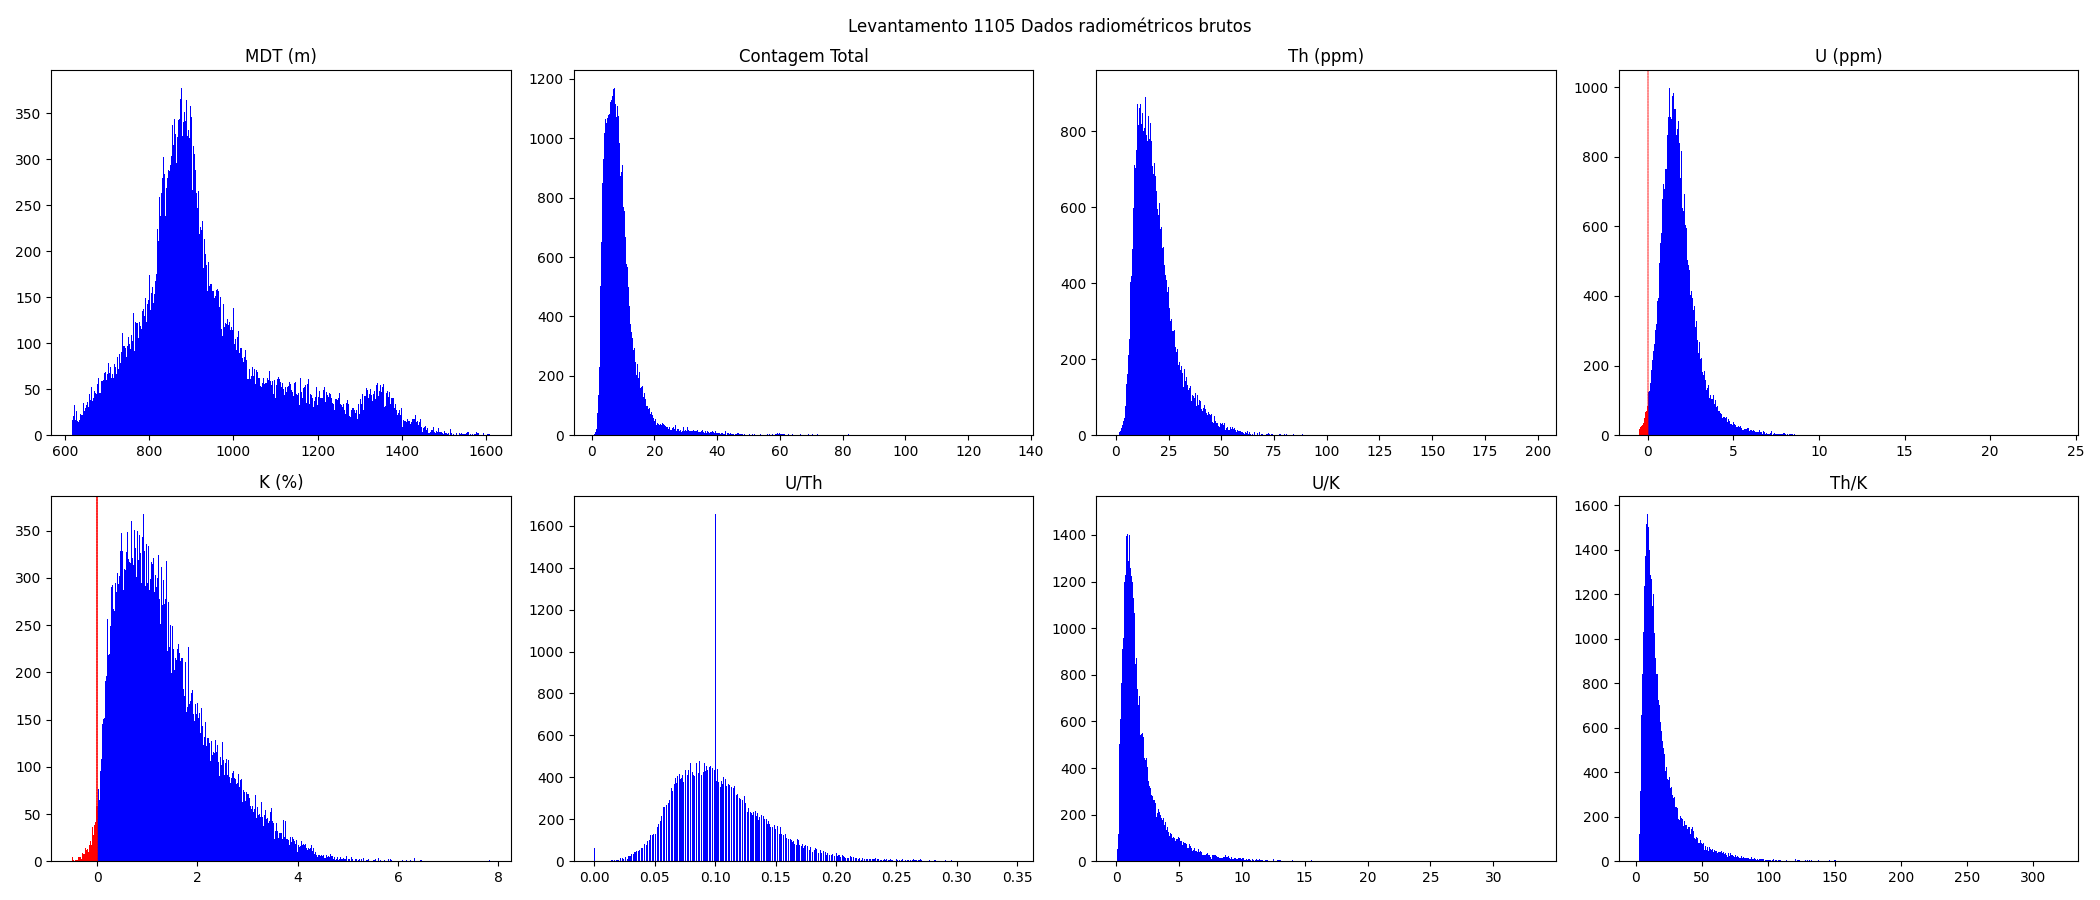

In [22]:
plot_histograms(df,500,'Levantamento 1105 Dados radiométricos brutos')

# Interpolação dos dados Brutos

## Verde Splines

## Método Linear

In [23]:
list(quadricula['SF23_YA_III']['area'].keys())

['EPSG', 'geometry', 'geometry_proj', 'coords', 'area']

In [24]:
quadricula['SF23_YA_III']['area']['area']

(-47.0, -46.5, -22.5, -22.0)

In [25]:
traditional_interpolation(quadricula,'mag_line_1105','gama_line_1105','linear','geof_1105',extrapolate=True,projec='geog')
#traditional_interpolation(quadricula,'mag_1039','gama_1039','linear','geof_1039',extrapolate=True)
#traditional_interpolation(quadricula,'mag_3022','gama_3022','linear','geof_3022')

  0%|                                                                   | 0/29 [00:00<?, ?it/s]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std     min        1%      25%     50%  \
CTCOR     22615.0   19.606257    6.869289    4.90    7.7000   14.700   18.80   
eU        22615.0    0.979701    0.508259   -0.47    0.0400    0.620    0.93   
eTh       22615.0   12.026269    4.772611    0.06    3.7900    8.600   11.44   
KPERC     22615.0    1.039137    0.676040   -0.42    0.0700    0.540    0.89   
UTHRAZAO  22615.0    0.093602    0.027162    0.00    0.0000    0.100    0.10   
THKRAZAO  22615.0   14.182978    6.898945    4.07    6.2600    9.690   12.23   
UKRAZAO   22615.0    1.261521    0.891023    0.10    0.3000    0.700    1.00   
MDT       22615.0  872.723337  139.942185  571.00  597.3626  773.835  853.56   

             75%       90%       99.9%      max  
CTCOR      23.50    28.600    52.13860    63.30  
eU          1.27     1.630     3.35386    

  3%|██                                                         | 1/29 [00:06<03:10,  6.81s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count         mean         std      min         1%     25%  \
CTCOR     38926.0    28.198579   17.629729    0.600    7.72125   18.00   
eU        38926.0     1.754739    1.678225   -0.480    0.07000    0.85   
eTh       38926.0    18.253396   11.135605    0.030    4.36000   11.34   
KPERC     38926.0     1.433505    0.902212   -0.420    0.14000    0.75   
UTHRAZAO  38926.0     0.099112    0.035539    0.000    0.00000    0.10   
THKRAZAO  38926.0    14.853895    8.620150    3.040    5.91000    9.51   
UKRAZAO   38926.0     1.457784    1.146928    0.061    0.20000    0.70   
MDT       38926.0  1011.530392  207.111957  649.980  711.36000  843.80   

              50%         75%        90%       99.9%       max  
CTCOR      23.900    32.30000    46.7000   163.44750   246.600  
eU          1.290     1.97000     3.5585    15.30375    23.934  
e

  7%|████                                                       | 2/29 [00:18<04:27,  9.92s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std      min         1%        25%  \
CTCOR     40452.0    9.305455    7.075647    0.916    2.44751    5.44875   
eU        40452.0    1.850431    1.186188   -0.488   -0.02898    1.12000   
eTh       40452.0   19.129646   10.494922    0.557    5.25206   11.88400   
KPERC     40452.0    1.387899    0.953039   -0.499   -0.00300    0.66600   
UTHRAZAO  40452.0    0.104245    0.039522    0.000    0.03400    0.07700   
THKRAZAO  40452.0   20.260648   18.387154    2.830    4.04200    9.24000   
UKRAZAO   40452.0    2.043708    1.910205    0.061    0.24800    0.90000   
MDT       40452.0  940.394256  173.976397  617.280  652.13000  833.85000   

               50%         75%        90%        99.9%       max  
CTCOR       7.8185    10.73300    15.0939    76.029400   134.100  
eU          1.6510     2.31900     3.1970   

 10%|██████                                                     | 3/29 [00:31<04:48, 11.08s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count         mean         std      min         1%      25%  \
CTCOR     76572.0     7.583173    3.691173    0.687    2.16971    4.972   
eU        76572.0     1.648448    0.929053   -0.499   -0.07829    1.044   
eTh       76572.0    20.075399   11.495986   -0.410    4.72100   11.635   
KPERC     76572.0     0.871150    0.737680   -0.499   -0.08700    0.374   
UTHRAZAO  76572.0     0.095647    0.048707    0.007    0.03000    0.064   
THKRAZAO  76572.0    35.334961   31.393162    1.359    3.76371   15.521   
UKRAZAO   76572.0     3.045191    2.599095    0.046    0.29500    1.329   
MDT       76572.0  1107.770864  192.644679  758.250  823.09710  927.720   

                50%         75%        90%        99.9%       max  
CTCOR        6.9090     9.44000    12.2740    31.940323    63.648  
eU           1.5500     2.12300     2.7510     7.50

 21%|████████████▏                                              | 6/29 [00:57<03:39,  9.53s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count         mean         std      min         1%        25%  \
CTCOR     74864.0     7.691513    3.377357   -0.718    2.00100    5.30900   
eU        74864.0     1.488363    0.849435   -0.499   -0.12737    0.90700   
eTh       74864.0    20.898516   10.262345   -1.967    4.85763   13.32875   
KPERC     74864.0     0.916862    0.615634   -0.496   -0.04800    0.46300   
UTHRAZAO  74864.0     0.077181    0.030371    0.007    0.02700    0.05800   
THKRAZAO  74864.0    32.725566   28.291065    1.707    4.90026   14.34500   
UKRAZAO   74864.0     2.375848    2.143943    0.064    0.31100    1.05900   
MDT       74864.0  1171.703524  226.699593  655.680  795.05520  968.42000   

                50%         75%        90%        99.9%       max  
CTCOR        7.1620     9.47125    12.1000    24.847000    41.366  
eU           1.3980     1.96300  

 24%|██████████████▏                                            | 7/29 [01:22<04:49, 13.16s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std      min         1%       25%  \
CTCOR     37295.0   12.339829    5.682020   -1.357    2.44658    7.7045   
eU        37295.0    1.712912    0.827618   -0.486    0.02494    1.1370   
eTh       37295.0   18.882067    6.580835   -2.163    5.51662   14.0260   
KPERC     37295.0    0.789376    0.532441   -0.499   -0.09700    0.4110   
UTHRAZAO  37295.0    0.094276    0.032335    0.011    0.03500    0.0720   
THKRAZAO  37295.0   34.069114   27.126104    3.183    6.15794   16.9705   
UKRAZAO   37295.0    3.072898    2.534084    0.102    0.49000    1.4880   
MDT       37295.0  757.283450  143.577124  558.500  570.54880  648.7600   

              50%       75%       90%        99.9%       max  
CTCOR      11.604   16.6980   20.2076    30.395298    35.676  
eU          1.665    2.2260    2.7760     5.062824     7.716 

 28%|████████████████▎                                          | 8/29 [01:33<04:24, 12.59s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std    min       1%       25%       50%  \
CTCOR     22332.0    8.288059    7.708331 -7.038 -1.95100   0.18100    9.3265   
eU        22332.0    0.931653    0.958270 -0.496 -0.14069   0.01400    0.8400   
eTh       22332.0    9.836329    9.362645 -2.354 -0.33900   0.08600   10.2750   
KPERC     22332.0    0.538968    0.614903 -0.464 -0.06200   0.01100    0.3840   
UTHRAZAO  22332.0    0.097982    0.045646  0.011  0.03400   0.08600    0.0900   
THKRAZAO  22332.0   24.350404   19.595047  1.658  4.87155  15.33100   19.8400   
UKRAZAO   22332.0    2.237893    1.731909  0.081  0.37331   1.51975    1.8000   
MDT       22332.0  463.243846  386.880893 -0.010  0.00000   0.00000  747.3200   

               75%       90%       99.9%       max  
CTCOR      13.4330   17.8924   38.131175    43.293  
eU          1.5960    2.208

 31%|██████████████████▎                                        | 9/29 [01:40<03:44, 11.25s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std      min         1%      25%  \
CTCOR     80239.0    6.374614    2.286117    0.223    2.52000    4.815   
eU        80239.0    1.401670    0.732345   -0.499   -0.06900    0.899   
eTh       80239.0   15.766465    6.948799   -0.606    4.99138   10.694   
KPERC     80239.0    0.582749    0.463660   -0.446   -0.06700    0.260   
UTHRAZAO  80239.0    0.099131    0.049174    0.009    0.03000    0.064   
THKRAZAO  80239.0   44.856792   42.190493    2.198    5.46752   16.643   
UKRAZAO   80239.0    3.766767    3.137769    0.101    0.38638    1.631   
MDT       80239.0  927.740985  111.538013  804.000  811.10000  857.030   

              50%       75%        90%        99.9%       max  
CTCOR       6.077    7.5510     9.2110    20.903524    26.936  
eU          1.349    1.8370     2.3250     4.768858     7.087  
eTh 

 38%|██████████████████████                                    | 11/29 [02:07<03:38, 12.16s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count         mean         std      min         1%       25%  \
CTCOR     80287.0     8.436172    3.118905    0.258    2.79200    6.3960   
eU        80287.0     1.575479    0.912394   -0.500   -0.16114    0.9275   
eTh       80287.0    20.544636    8.039419   -1.096    5.30700   15.1210   
KPERC     80287.0     0.802110    0.531738   -0.484   -0.07500    0.4250   
UTHRAZAO  80287.0     0.079143    0.031222    0.005    0.02500    0.0580   
THKRAZAO  80287.0    36.302784   30.113076    1.669    4.87044   17.2790   
UKRAZAO   80287.0     2.826135    2.521235    0.067    0.27700    1.2040   
MDT       80287.0  1141.272070  356.407740  532.420  538.11860  890.4000   

               50%        75%        90%        99.9%       max  
CTCOR        8.179    10.0405    12.0304    25.827998    41.996  
eU           1.496     2.1300     2.7724     5

 41%|████████████████████████                                  | 12/29 [02:34<04:25, 15.59s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std      min         1%        25%  \
CTCOR     86928.0   15.401055    7.494597   -2.255    2.69954   10.01900   
eU        86928.0    2.196892    0.977259   -0.498    0.16100    1.53500   
eTh       86928.0   23.025253    9.837460   -0.794    5.61581   16.26300   
KPERC     86928.0    0.988819    0.748584   -0.486   -0.02100    0.49300   
UTHRAZAO  86928.0    0.101176    0.031927    0.007    0.04500    0.08000   
THKRAZAO  86928.0   32.549590   24.608860    3.876    7.73027   16.64975   
UKRAZAO   86928.0    3.199321    2.512517    0.123    0.65300    1.61475   
MDT       86928.0  700.772828  115.120581  530.170  540.93000  607.67000   

              50%        75%       90%        99.9%       max  
CTCOR      14.167   19.50200   24.6530    52.140482    96.652  
eU          2.147    2.78400    3.4240     6.46207

 45%|██████████████████████████                                | 13/29 [03:00<04:53, 18.36s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std    min       1%       25%      50%  \
CTCOR     37912.0   12.898445    7.000763 -4.545  0.15755    8.1570   11.656   
eU        37912.0    1.789308    0.988941 -0.500 -0.11189    1.1130    1.725   
eTh       37912.0   16.800632    8.311108 -2.060  0.05611   11.1405   15.844   
KPERC     37912.0    0.838070    0.691549 -0.498 -0.10700    0.3620    0.670   
UTHRAZAO  37912.0    0.114837    0.054283  0.005  0.03600    0.0860    0.107   
THKRAZAO  37912.0   29.513584   24.500419  1.185  5.61922   13.7510   21.550   
UKRAZAO   37912.0    3.240923    2.829027  0.060  0.43511    1.4460    2.338   
MDT       37912.0  822.398897  234.312937 -2.320  0.00000  764.3700  857.790   

              75%        90%        99.9%       max  
CTCOR      16.316    21.6609    50.997811    82.359  
eU          2.387     3.0580     6

 48%|████████████████████████████                              | 14/29 [03:12<04:09, 16.63s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count         mean         std      min         1%      25%  \
CTCOR     77273.0     8.283720    4.989986   -2.947    2.07344    5.173   
eU        77273.0     1.648416    0.984593   -0.500   -0.18800    0.960   
eTh       77273.0    16.128572    7.560887   -2.071    3.91372   10.821   
KPERC     77273.0     0.680794    0.506426   -0.499   -0.18400    0.336   
UTHRAZAO  77273.0     0.110032    0.053311    0.005    0.02700    0.075   
THKRAZAO  77273.0    31.268069   22.264576    1.874    7.01644   16.747   
UKRAZAO   77273.0     3.322971    2.769059    0.105    0.42900    1.577   
MDT       77273.0  1162.205228  259.910598  724.530  850.02440  943.610   

               50%       75%        90%        99.9%       max  
CTCOR        7.203     9.984    13.1626    43.325848    64.106  
eU           1.553     2.213     2.9110     6.074920     

 55%|████████████████████████████████                          | 16/29 [03:37<03:13, 14.87s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std      min         1%      25%  \
CTCOR     79157.0   17.326450    9.022218   -1.677    3.34480   10.102   
eU        79157.0    2.119607    0.965269   -0.499    0.04856    1.479   
eTh       79157.0   22.062014    8.149556   -3.080    6.39100   16.498   
KPERC     79157.0    1.071097    0.763794   -0.497   -0.09400    0.534   
UTHRAZAO  79157.0    0.100755    0.038739    0.006    0.03700    0.079   
THKRAZAO  79157.0   29.251539   23.431283    1.079    5.51024   15.187   
UKRAZAO   79157.0    2.828666    2.496200    0.081    0.55800    1.393   
MDT       79157.0  867.236613  407.699502  513.280  521.46000  559.080   

              50%       75%        90%        99.9%       max  
CTCOR      15.913    23.036    29.8414    59.492128    85.820  
eU          2.085     2.699     3.3020     6.345000     8.980  
eTh 

 59%|██████████████████████████████████                        | 17/29 [04:01<03:23, 16.94s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std    min       1%       25%      50%  \
CTCOR     95890.0   19.022490    9.801125 -4.644  1.39089   12.4350   17.339   
eU        95890.0    2.107613    1.016924 -0.495 -0.03000    1.4540    2.040   
eTh       95890.0   20.608233    9.411082 -1.878 -0.05111   15.0660   19.345   
KPERC     95890.0    1.115539    0.974789 -0.498 -0.09100    0.4530    0.854   
UTHRAZAO  95890.0    0.107034    0.036539  0.010  0.04100    0.0850    0.102   
THKRAZAO  95890.0   29.284119   24.920161  1.214  5.72289   14.2100   20.523   
UKRAZAO   95890.0    3.108518    2.862012  0.063  0.48400    1.3700    2.151   
MDT       95890.0  839.921252  262.393287  0.000  0.00000  767.6125  861.785   

                75%        90%        99.9%       max  
CTCOR      23.70475    31.2540    72.503660   140.311  
eU          2.68500     3.3800

 62%|████████████████████████████████████                      | 18/29 [04:28<03:33, 19.39s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std     min       1%     25%      50%  \
CTCOR     18565.0    9.436355    9.453657 -11.575 -2.43636   1.270    8.449   
eU        18565.0    1.207712    1.187357  -0.500 -0.21736   0.071    1.080   
eTh       18565.0   10.708011   10.130772  -4.048 -0.75308   0.104   10.624   
KPERC     18565.0    0.608797    0.768650  -0.489 -0.13136   0.018    0.355   
UTHRAZAO  18565.0    0.111929    0.056770   0.008  0.03500   0.090    0.090   
THKRAZAO  18565.0   26.325283   23.339697   0.940  4.42264  14.827   19.840   
UKRAZAO   18565.0    2.765902    2.491177   0.065  0.38400   1.723    1.800   
MDT       18565.0  342.846323  362.915176  -4.100  0.00000   0.000  169.600   

              75%       90%       99.9%       max  
CTCOR      13.937   21.1820   57.074496   140.311  
eU          1.984    2.7430    6.910864    10.8

 66%|██████████████████████████████████████                    | 19/29 [04:34<02:39, 15.94s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count         mean         std      min         1%        25%  \
CTCOR     46508.0    13.169434    9.958900   -3.159    2.23114    7.38575   
eU        46508.0     2.026511    1.083508   -0.500   -0.06793    1.28200   
eTh       46508.0    19.973572   10.314942   -2.982    3.73242   13.47200   
KPERC     46508.0     1.008605    0.912599   -0.500   -0.18400    0.44500   
UTHRAZAO  46508.0     0.116334    0.072430    0.005    0.02900    0.07500   
THKRAZAO  46508.0    28.524313   22.272637    0.798    6.23714   15.02300   
UKRAZAO   46508.0     3.043374    2.606492    0.062    0.40800    1.51300   
MDT       46508.0  1315.271355  437.112290  395.140  410.60140  982.91500   

                50%         75%        90%        99.9%       max  
CTCOR       10.3800    15.09825    24.5450    74.001339   162.375  
eU           1.9110     2.64100  

 72%|██████████████████████████████████████████                | 21/29 [04:49<01:39, 12.39s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std    min         1%        25%  \
CTCOR     70338.0   25.338213    9.419719  0.695    9.36800   19.08025   
eU        70338.0    2.173354    0.920754 -0.492    0.33400    1.55500   
eTh       70338.0   25.213438    9.936256 -2.763    8.35074   18.72200   
KPERC     70338.0    1.159750    0.809502 -0.498   -0.10563    0.63700   
UTHRAZAO  70338.0    0.089661    0.025066  0.005    0.03900    0.07400   
THKRAZAO  70338.0   27.238376   17.653819  1.979    6.64400   17.43225   
UKRAZAO   70338.0    2.417816    1.706084  0.092    0.57837    1.40800   
MDT       70338.0  989.443206  357.595799  2.100  442.59740  647.80000   

              50%         75%        90%        99.9%       max  
CTCOR      24.002    29.89700    37.0755    73.615706   210.609  
eU          2.086     2.68400     3.3353     6.573652    10.933 

 76%|████████████████████████████████████████████              | 22/29 [05:10<01:40, 14.40s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std    min       1%       25%       50%  \
CTCOR     80342.0   16.137255   14.859126 -4.644  0.02541   1.98225   14.8580   
eU        80342.0    1.193157    1.287201 -0.497 -0.13200   0.00400    0.9820   
eTh       80342.0   15.182482   16.458752 -1.736 -0.48700   0.06300   13.5975   
KPERC     80342.0    0.898147    1.094791 -0.497 -0.13200   0.01200    0.5050   
UTHRAZAO  80342.0    0.087273    0.026005  0.003  0.03100   0.07700    0.0900   
THKRAZAO  80342.0   20.476785   10.725546  0.871  6.13941  16.60225   19.8400   
UKRAZAO   80342.0    1.775158    1.071540  0.063  0.38441   1.29900    1.8000   
MDT       80342.0  487.415949  548.742315  0.000  0.00000   0.00000  145.1750   

                 75%        90%        99.9%       max  
CTCOR       25.42675    35.9660    81.001452   113.602  
eU           2.0880

 79%|██████████████████████████████████████████████            | 23/29 [05:34<01:40, 16.77s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std      min         1%        25%  \
CTCOR     72848.0   18.437270    8.768266   -2.772    3.21647   11.91900   
eU        72848.0    2.120748    0.966085   -0.495    0.21047    1.45275   
eTh       72848.0   24.654711   10.824150   -2.097    4.80500   16.46000   
KPERC     72848.0    0.934856    0.760781   -0.497   -0.18900    0.43300   
UTHRAZAO  72848.0    0.097306    0.053752    0.008    0.03400    0.06500   
THKRAZAO  72848.0   37.404759   30.221065    2.441    7.02500   18.96100   
UKRAZAO   72848.0    3.318787    2.692251    0.132    0.48200    1.65200   
MDT       72848.0  816.581160  337.068476  360.530  384.88410  522.19000   

               50%         75%        90%        99.9%       max  
CTCOR      17.7600    23.66225    29.5873    57.358743    76.399  
eU          2.0465     2.69925     3.3600   

 86%|██████████████████████████████████████████████████        | 25/29 [05:57<00:58, 14.57s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std    min       1%       25%      50%  \
CTCOR     73667.0   23.515371   10.326850 -3.657  1.40200   16.9765   22.038   
eU        73667.0    2.260740    1.012850 -0.497  0.04800    1.6130    2.201   
eTh       73667.0   24.407595   10.869297 -2.040  0.00266   18.0040   23.462   
KPERC     73667.0    1.623235    1.243823 -0.497 -0.10500    0.7030    1.305   
UTHRAZAO  73667.0    0.096769    0.029804  0.005  0.03900    0.0790    0.094   
THKRAZAO  73667.0   21.725466   16.394800  1.959  4.95500   11.3495   18.167   
UKRAZAO   73667.0    2.129141    1.782678  0.042  0.35800    0.9840    1.670   
MDT       73667.0  648.656962  359.786608  0.000  0.00000  464.0750  540.040   

               75%        90%        99.9%       max  
CTCOR      28.3970    36.4264    76.759396   133.491  
eU          2.8380     3.5060   

 90%|████████████████████████████████████████████████████      | 26/29 [06:20<00:49, 16.53s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count       mean         std    min       1%     25%     50%  \
CTCOR     39856.0   6.318142   10.886173 -4.936 -0.73800   0.673   1.542   
eU        39856.0   0.415060    0.926385 -0.499 -0.16045  -0.026   0.010   
eTh       39856.0   5.386851   12.290967 -1.849 -0.69945  -0.035   0.077   
KPERC     39856.0   0.448834    1.006723 -0.490 -0.13100   0.004   0.024   
UTHRAZAO  39856.0   0.088633    0.020919  0.006  0.03900   0.090   0.090   
THKRAZAO  39856.0  18.734262    5.347353  1.857  4.84110  19.840  19.840   
UKRAZAO   39856.0   1.666290    0.539592  0.060  0.32055   1.800   1.800   
MDT       39856.0  49.283809  138.239012  0.000  0.00000   0.000   0.000   

               75%       90%       99.9%       max  
CTCOR      4.87825   22.6870   67.124455   104.660  
eU         0.26725    1.7520    6.054625     8.953  
eTh        1.11525 

100%|██████████████████████████████████████████████████████████| 29/29 [06:33<00:00, 13.56s/it]


In [26]:
ds_c = quadricula['SF23_YA_III']['geof_1105_linear']
#ds_d = quadricula['SF23_VD']['geof_1105_linear']
#ds_a = quadricula['SF23_YA']['geof_1105_linear']
#ds_b = quadricula['SF23_YB']['geof_1105_linear']


In [27]:
ds_c

<xarray.Dataset>
Dimensions:    (LATITUDE: 500, LONGITUDE: 500)
Coordinates:
  * LATITUDE   (LATITUDE) float64 -22.5 -22.5 -22.5 -22.5 ... -22.0 -22.0 -22.0
  * LONGITUDE  (LONGITUDE) float64 -47.0 -47.0 -47.0 -47.0 ... -46.5 -46.5 -46.5
Data variables:
    MDT        (LATITUDE, LONGITUDE) float64 nan nan nan ... 1.315e+03 1.318e+03
    CTCOR      (LATITUDE, LONGITUDE) float64 nan nan nan nan ... 13.49 16.8 20.1
    KPERC      (LATITUDE, LONGITUDE) float64 nan nan nan ... 1.381 1.245 1.109
    eU         (LATITUDE, LONGITUDE) float64 nan nan nan ... 4.188 4.623 5.057
    eTh        (LATITUDE, LONGITUDE) float64 nan nan nan ... 44.76 52.28 59.81
    GMT        (LATITUDE, LONGITUDE) float64 nan nan nan ... 1.729 1.206 0.6838
    UTHRAZAO   (LATITUDE, LONGITUDE) float64 nan nan nan ... 0.09299 0.08341
    UKRAZAO    (LATITUDE, LONGITUDE) float64 nan nan nan ... 3.129 3.466 3.803
    THKRAZAO   (LATITUDE, LONGITUDE) float64 nan nan nan nan ... 33.29 42.8 52.3

NameError: name 'ds_a' is not defined

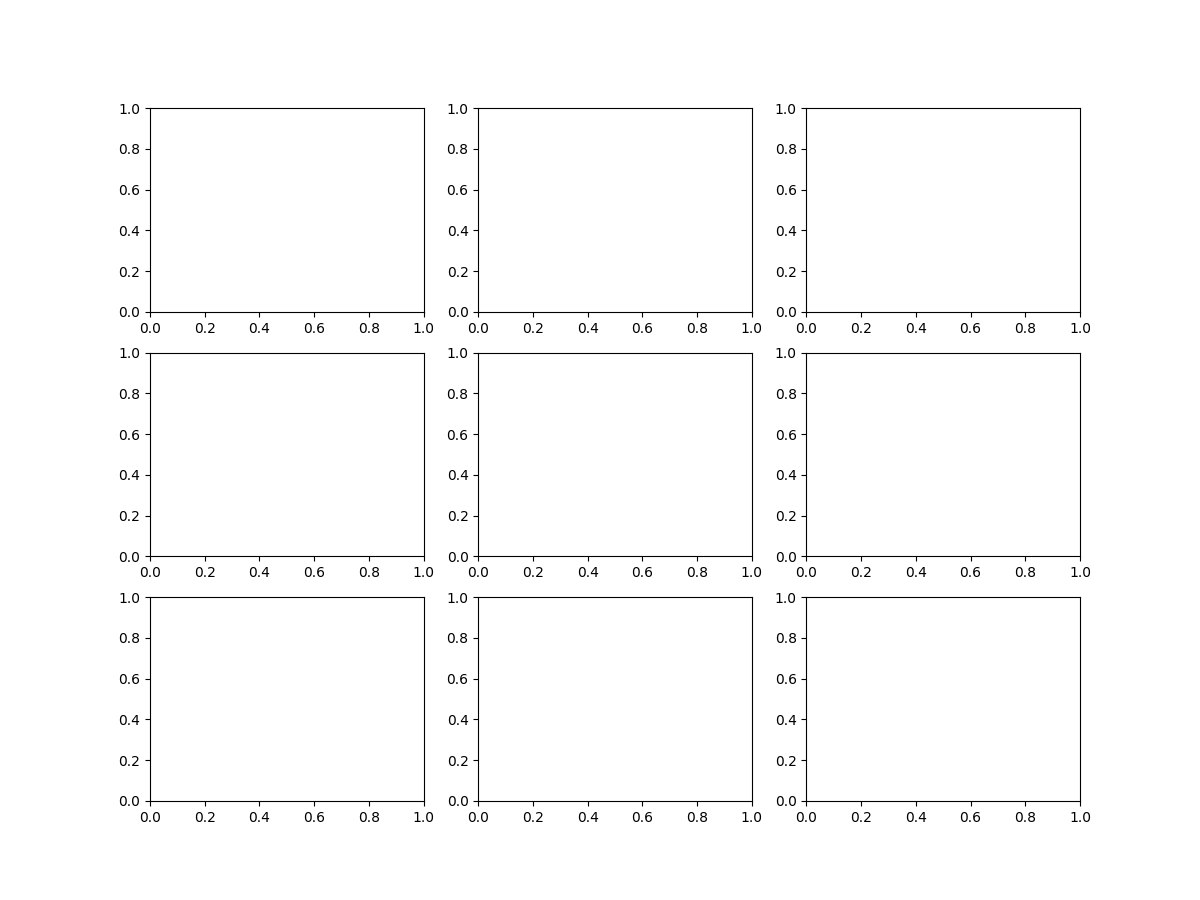

In [28]:
fig, axes = plt.subplots(3,3,figsize=(12,9))
list_data = list(ds_c.keys())
for i,ax in enumerate(axes.flatten()):
    
    if i < len(list_data):
        if list_data[i] == 'GMT':
            ax.imshow(ds_a[list_data[i]],cmap='bwr')
            ax.set(title=ds_a[list_data[i]].name)
        elif list_data[i]=='MDT':
            ax.imshow(ds_a[list_data[i]],cmap='terrain')
            ax.set(title=ds_a[list_data[i]].name)
        
        else:
            ax.imshow(ds_a[list_data[i]])
            ax.set(title=ds_a[list_data[i]].name)

NameError: name 'ds_a' is not defined

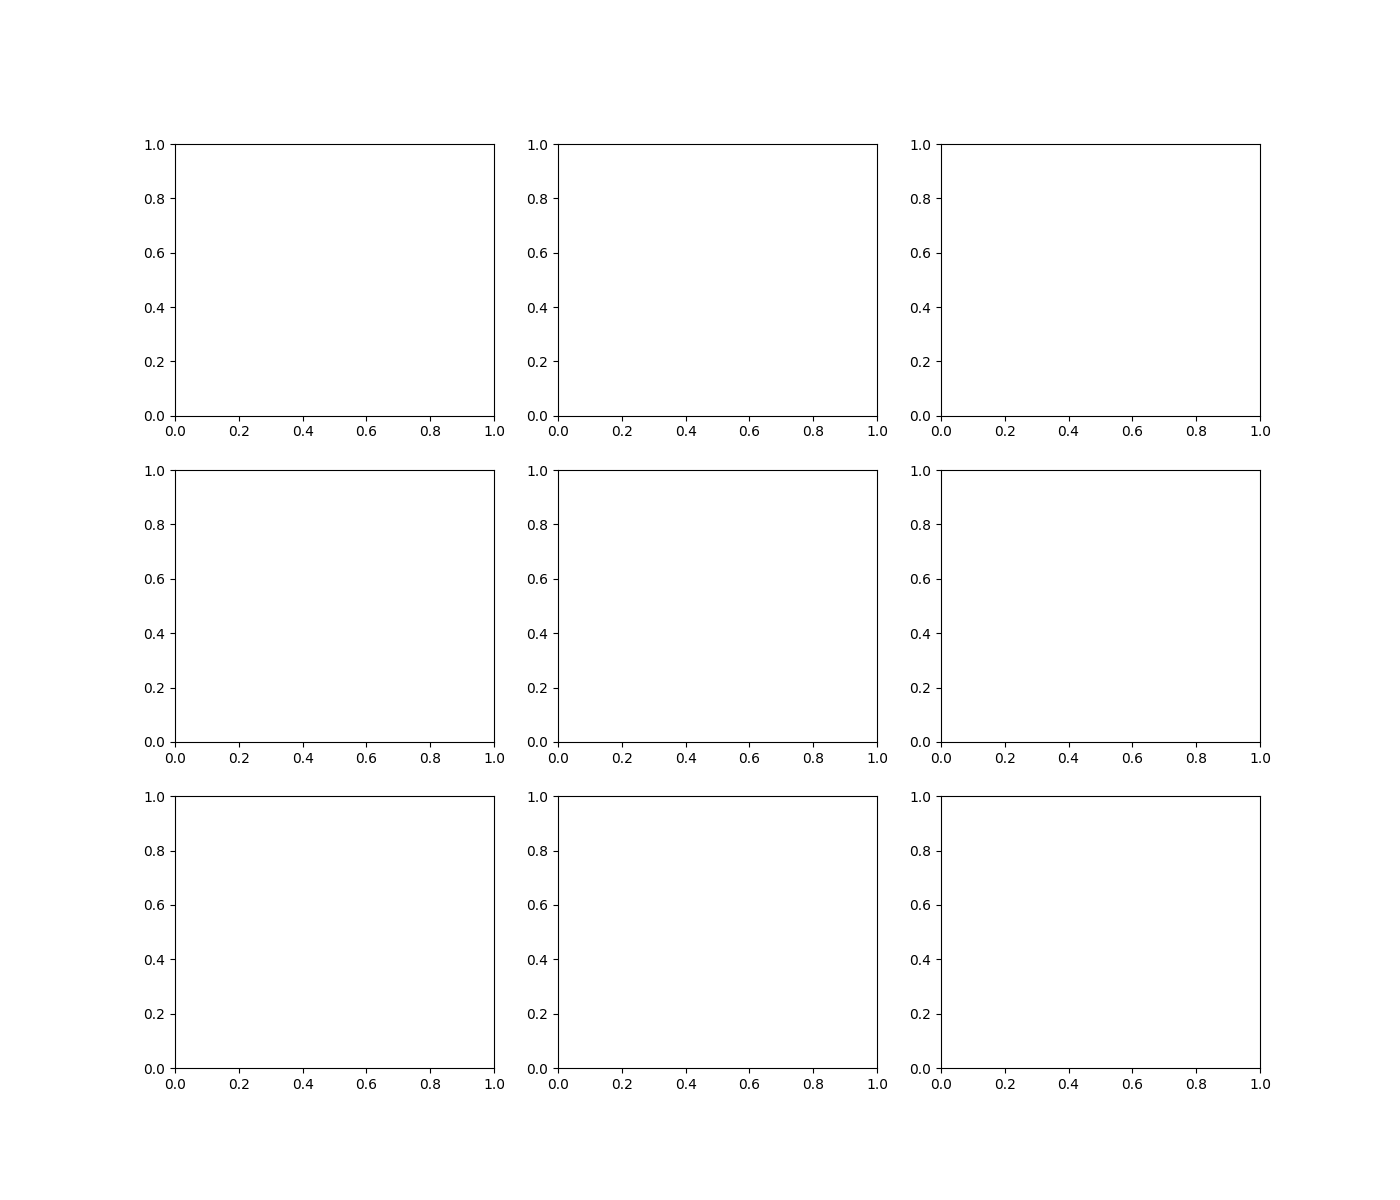

In [29]:
fig, axes = plt.subplots(3,3,figsize=(14,12))
list_data = list(ds_a.keys())
for i,ax in enumerate(axes.flatten()):
    
    if i < len(list_data):
        if list_data[i] == 'GMT':
            ax.imshow(ds_a[list_data[i]],cmap='bwr')
            ax.set(title=ds_a[list_data[i]].name)
        elif list_data[i]=='MDT':
            ax.imshow(ds_a[list_data[i]],cmap='terrain')
            ax.set(title=ds_a[list_data[i]].name)
        
        else:
            ax.imshow(ds_a[list_data[i]])
            ax.set(title=ds_a[list_data[i]].name)

# Classificações Não-Supervisionadas

## Rotulando amostras com classes litológicas

In [30]:
'''
import shapely.speedups
from shapely import geometry
shapely.speedups.enable()

#geof_1089_linear['geometry'] = [geometry.Point(x,y) for x, y in zip(geof_1089_linear['X'], geof_1089_linear['Y'])]
#gdf_1089_linear = geof_1089_linear.set_geometry('geometry')

#gdf_1089_linear.set_crs('EPSG:32723',inplace=True)
#gdf_1089_linear.geometry

#Upload_litologia(quadricula,'litologia_100k')

litologia=quadricula['SB24_ZB_II']['litologia_100k']
litologia.to_crs('EPSG:32724',inplace=True)
print(litologia.crs)
litologia.reset_index(drop=True,inplace=True)

dic_litologico = describe_geologico(litologia)
print(litologia.columns)

#print(dic_litologico['SIGLA']['len'])
#print(dic_litologico['SIGLA']['lista'])

#litologia.plot('SIGLA',figsize=(16,16),legend=True)

#geof_1089_linear['closest_unit'] = geof_1089_linear['geometry'].apply(lambda x: litologia['SIGLA'].iloc[litologia.distance(x).idxmin()]) # .idxmin() Retorna o indice do menor valor 

#geof_1089_linear.to_csv('/home/ggrl/database/csv/SB24_ZB_II_gama_linear_100m.csv',index=False)
'''

"\nimport shapely.speedups\nfrom shapely import geometry\nshapely.speedups.enable()\n\n#geof_1089_linear['geometry'] = [geometry.Point(x,y) for x, y in zip(geof_1089_linear['X'], geof_1089_linear['Y'])]\n#gdf_1089_linear = geof_1089_linear.set_geometry('geometry')\n\n#gdf_1089_linear.set_crs('EPSG:32723',inplace=True)\n#gdf_1089_linear.geometry\n\n#Upload_litologia(quadricula,'litologia_100k')\n\nlitologia=quadricula['SB24_ZB_II']['litologia_100k']\nlitologia.to_crs('EPSG:32724',inplace=True)\nprint(litologia.crs)\nlitologia.reset_index(drop=True,inplace=True)\n\ndic_litologico = describe_geologico(litologia)\nprint(litologia.columns)\n\n#print(dic_litologico['SIGLA']['len'])\n#print(dic_litologico['SIGLA']['lista'])\n\n#litologia.plot('SIGLA',figsize=(16,16),legend=True)\n\n#geof_1089_linear['closest_unit'] = geof_1089_linear['geometry'].apply(lambda x: litologia['SIGLA'].iloc[litologia.distance(x).idxmin()]) # .idxmin() Retorna o indice do menor valor \n\n#geof_1089_linear.to_csv('/h

## Self-organizing maps (SOM)

### Pixel size

In [31]:
#help(pcolormesh)

Help on function pcolormesh in module matplotlib.pyplot:

pcolormesh(*args, alpha=None, norm=None, cmap=None, vmin=None, vmax=None, shading=None, antialiased=False, data=None, **kwargs)
    Create a pseudocolor plot with a non-regular rectangular grid.
    
    Call signature::
    
        pcolormesh([X, Y,] C, **kwargs)
    
    *X* and *Y* can be used to specify the corners of the quadrilaterals.
    
    .. hint::
    
       `~.Axes.pcolormesh` is similar to `~.Axes.pcolor`. It is much faster
       and preferred in most cases. For a detailed discussion on the
       differences see :ref:`Differences between pcolor() and pcolormesh()
       <differences-pcolor-pcolormesh>`.
    
    Parameters
    ----------
    C : array-like
        A scalar 2-D array. The values will be color-mapped.
    
    X, Y : array-like, optional
        The coordinates of the corners of quadrilaterals of a pcolormesh::
    
            (X[i+1, j], Y[i+1, j])       (X[i+1, j+1], Y[i+1, j+1])
            

In [36]:
print(list(quadricula.keys()))
print('')
print(quadricula['SF23_YA'].keys())
print('')
ds_a = quadricula['SF23_YA']['geof_1105_linear']
ds_b = quadricula['SF23_YB']['geof_1105_linear']

['SF23_VC_III', 'SF23_VC_VI', 'SF23_YA_III', 'SF23_YA_VI', 'SF23_VD_IV', 'SF23_YB_I', 'SF23_YB_IV', 'SF23_YD_I', 'SF23_YD_IV', 'SF23_VD_V', 'SF23_YB_II', 'SF23_YB_V', 'SF23_YD_II', 'SF23_YD_V', 'SF23_VD_VI', 'SF23_YB_III', 'SF23_YB_VI', 'SF23_YD_III', 'SF23_YD_VI', 'SF23_XC_IV', 'SF23_ZA_I', 'SF23_ZA_IV', 'SF23_ZC_I', 'SF23_XC_V', 'SF23_ZA_II', 'SF23_ZA_V', 'SF23_ZC_II', 'SF23_ZA_III', 'SF23_ZA_VI']



KeyError: 'SF23_YA'

In [37]:
ds_b.LONGITUDE.values.max()

NameError: name 'ds_b' is not defined

In [ ]:
ds_a.LONGITUDE.values.max()

In [ ]:
ds_b

In [ ]:
ds_b['LATITUDE']

In [ ]:
ds_a['LATITUDE']

In [ ]:
ds = xr.combine_by_coords([ds_a,ds_b])

In [ ]:
#for id in tqdm(list(quadricula.keys())):
#    ds = quadricula[id]['geof_1105_linear']
features = list(ds.keys())
print(features)

In [ ]:
df = ds[features].to_dataframe()
df = df.reset_index()
df

In [ ]:
xpixel_size = (ds.LONGITUDE.max().values-ds.LONGITUDE.min().values)/ds.LONGITUDE.size
ypixel_size = (ds.LATITUDE.max().values-ds.LATITUDE.min().values)/ds.LATITUDE.size
print('x:', xpixel_size, 'y:', ypixel_size)

In [ ]:
nx = ds.LATITUDE.size
ny = ds.LONGITUDE.size

print(ny,nx,ny/nx)

xs = df.LONGITUDE.values.reshape(nx,ny)
ys = df.LATITUDE.values.reshape(nx,ny)

In [ ]:
def plot_corr(dataframe, size=10):
    plt.figure(figsize = (size+size*0.2, size), facecolor='w')
    corrMatrix = dataframe.corr()
    sns.heatmap(np.round(corrMatrix,2), annot=True,vmin=-1,vmax=1,cmap='bwr',center=0)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0, ha='right')

plot_corr(df, size=12)
#plt.savefig('figs/correlation_matrix.png', dpi=400, bbox_inches='tight')

In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(df[features].values)
data.shape

In [ ]:
n_clusters=4
lito_SOM = SOM(m=n_clusters, n=1, sigma=1.5, dim=len(features), max_iter=50)
lito_SOM.fit(data)

In [ ]:
# predição de classes
predictions = lito_SOM.predict(data)

In [ ]:
# create labels
cluster_labels=[]
for i in range(n_clusters):
    cluster_labels+=[f'Classe {i+1}']

In [ ]:
# classes weights
fig, ax = plt.subplots(figsize=(19,19))
im=ax.matshow(lito_SOM.weights,cmap='bwr',vmin=-1.5,vmax=1.5)
for (i, j), z in np.ndenumerate(lito_SOM.weights):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.yticks(range(n_clusters), cluster_labels, fontsize=9)
plt.xticks(range(len(features)), features, rotation=55, fontsize=10, ha='left')
fig.colorbar(im, label='weights', orientation='horizontal')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10, 10)
plt.show()

In [ ]:
id_ = [1,2,3,4]
relcolor =  matplotlib.cm.Set3
colors = np.array(relcolor.colors)[id_]
relcolor = matplotlib.colors.ListedColormap(colors)

In [ ]:
idxs=np.arange(0, n_clusters, 1)
half=(idxs[1]-idxs[0])/2
ticks=np.linspace(idxs[0]+half, idxs[-1]-half, n_clusters)

In [ ]:
print(xs.shape,ys.shape)

In [ ]:
fig, ax=plt.subplots(figsize=(16, 16), facecolor='w')
im=plt.pcolormesh(xs, ys, predictions.reshape(ny, nx), cmap=relcolor, shading='auto')
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels, fontsize=8)
plt.suptitle('SOM - Aerogeophysical Data (SF23_YB_I)')
plt.axis('scaled')
plt.show()

In [ ]:
features = ['MDT','GMT','F_factor']

scaler = StandardScaler()
data = scaler.fit_transform(df[features].values)
n_clusters=10
lito_SOM = SOM(m=n_clusters, n=1, sigma=1.5, dim=len(features), max_iter=10000)
lito_SOM.fit(data)
# predição de classes
predictions = lito_SOM.predict(data)
# create labels
cluster_labels=[]
for i in range(n_clusters):
    cluster_labels+=[f'Classe {i+1}']


# classes weights
fig, ax = plt.subplots(figsize=(19,19))
im=ax.matshow(lito_SOM.weights)
for (i, j), z in np.ndenumerate(lito_SOM.weights):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.yticks(range(n_clusters), cluster_labels, fontsize=9)
plt.xticks(range(len(features)), features, rotation=55, fontsize=10, ha='left')
fig.colorbar(im, label='weights', orientation='horizontal')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10, 10)
plt.show()
import matplotlib
id_ = [1,2,3,4,5,6,7,8,9,10]
relcolor =  matplotlib.cm.Set3
colors = np.array(relcolor.colors)[id_]
relcolor = matplotlib.colors.ListedColormap(colors)
idxs=np.arange(0, n_clusters, 1)
half=(idxs[1]-idxs[0])/2
ticks=np.linspace(idxs[0]+half, idxs[-1]-half, n_clusters)
fig, ax=plt.subplots(figsize=(16, 16), facecolor='w')
im=plt.pcolormesh(xs, ys, predictions.reshape(ny, nx), cmap=relcolor, shading='auto')
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels, fontsize=8)
plt.suptitle('SOM - Aerogeophysical Data ( Aguas de Lindóia - SF23_YA_III4)')
plt.axis('scaled')
plt.show()

In [ ]:
features = ['MDT','GMT','F_factor','CTCOR']

scaler = StandardScaler()
data = scaler.fit_transform(df[features].values)
n_clusters=10
lito_SOM = SOM(m=n_clusters, n=1, sigma=1.5, dim=len(features), max_iter=10000)
lito_SOM.fit(data)
# predição de classes
predictions = lito_SOM.predict(data)
# create labels
cluster_labels=[]
for i in range(n_clusters):
    cluster_labels+=[f'Classe {i+1}']


# classes weights
fig, ax = plt.subplots(figsize=(19,19))
im=ax.matshow(lito_SOM.weights)
for (i, j), z in np.ndenumerate(lito_SOM.weights):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.yticks(range(n_clusters), cluster_labels, fontsize=9)
plt.xticks(range(len(features)), features, rotation=55, fontsize=10, ha='left')
fig.colorbar(im, label='weights', orientation='horizontal')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10, 10)
plt.show()
import matplotlib
id_ = [1,2,3,4,5,6,7,8,9,10]
relcolor =  matplotlib.cm.Set3
colors = np.array(relcolor.colors)[id_]
relcolor = matplotlib.colors.ListedColormap(colors)
idxs=np.arange(0, n_clusters, 1)
half=(idxs[1]-idxs[0])/2
ticks=np.linspace(idxs[0]+half, idxs[-1]-half, n_clusters)
fig, ax=plt.subplots(figsize=(16, 16), facecolor='w')
im=plt.pcolormesh(xs, ys, predictions.reshape(ny, nx), cmap=relcolor, shading='auto')
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels, fontsize=8)
plt.suptitle('SOM - Aerogeophysical Data ( Aguas de Lindóia - SF23_YA_III4)')
plt.axis('scaled')
plt.show()

In [ ]:
# get attributes
features = list(SF23_YA_III_4.keys())
print(features)
# transform a xarray.Dataset into pandas.Dataframe
df = SF23_YA_III_4[features].to_dataframe()
df = df.reset_index()

In [ ]:
# visualize correlations
plot_corr(df, size=12)
# SELECT FEATURES
features = ['MDT','GMT','F_factor']
print(f' - Selected Features: {features}')

In [ ]:
# get pixel size
xpixel_size = (ds.LONGITUDE.max().values-ds.LONGITUDE.min().values)/ds.LONGITUDE.size
ypixel_size = (ds.LATITUDE.max().values-ds.LATITUDE.min().values)/ds.LATITUDE.size
print('x:', xpixel_size, 'y:', ypixel_size)
# get number of pixels
nx = ds.LATITUDE.size
ny = ds.LONGITUDE.size
print(f'x:{ny} ; y:{nx} | x/y: {ny/nx}')
# reshape numpy.array into tuple of arrays
xs = df.LONGITUDE.values.reshape(nx,ny)
ys = df.LATITUDE.values.reshape(nx,ny)
# transform - fit dataframe to scallar matrix of shape 250 x 250
scaler = StandardScaler()
data = scaler.fit_transform(df[features].values)
print(f' - Scalar shape:   {data.shape}')
# Clusters, n, sigma, iterations
n_clusters=10
lito_SOM = SOM(m=n_clusters, n=1, sigma=1.5, dim=len(features), max_iter=10000)
lito_SOM.fit(data)
# predição de classes
predictions = lito_SOM.predict(data)
# create labels
cluster_labels=[]
for i in range(n_clusters):
    cluster_labels+=[f'Classe {i+1}']
# classes weights
fig, ax = plt.subplots(figsize=(19,19))
im=ax.matshow(lito_SOM.weights)
for (i, j), z in np.ndenumerate(lito_SOM.weights):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
# 
plt.yticks(range(n_clusters), cluster_labels, fontsize=9)
plt.xticks(range(len(features)), features, rotation=55, fontsize=10, ha='left')
fig.colorbar(im, label='weights', orientation='horizontal')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10, 10)
plt.show()
import matplotlib
id_ = [1,2,3,4,5,6,7,8,9,10]
relcolor =  matplotlib.cm.Set3
colors = np.array(relcolor.colors)[id_]
relcolor = matplotlib.colors.ListedColormap(colors)
idxs=np.arange(0, n_clusters, 1)
half=(idxs[1]-idxs[0])/2
ticks=np.linspace(idxs[0]+half, idxs[-1]-half, n_clusters)
fig, ax=plt.subplots(figsize=(16, 16), facecolor='w')
im=plt.pcolormesh(xs, ys, predictions.reshape(ny, nx), cmap=relcolor, shading='auto')
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels, fontsize=8)
# 
plt.suptitle('SOM - Aerogeophysical Data ( Aguas de Lindóia - SF23_YA_III4)')
plt.axis('scaled')
plt.show()